# CSE527 Programming Assignment 3
**Due date: 2021.11.11 23:59 PM**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*




In [5]:
# pip install the OpenCV version from 'contrib'
%pip install opencv-contrib-python==3.4.2.17


     |████████████████████████████████| 30.6 MB 29 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Replace -----/-----/-----/' with the path such that "CSE527-PA3-fall21" is your working directory
%cd '/content/gdrive/MyDrive/CSE 527 - Fall 2021/Goel_Dinker_113271234_hw3'

/content/gdrive/MyDrive/CSE 527 - Fall 2021/Goel_Dinker_113271234_hw3


In [6]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torchvision
import gc
import os
import pickle
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import svm
import sklearn.metrics as metrics

print(cv2.__version__) # verify OpenCV version

3.4.2


In [7]:
!ls -lrt

total 1517698
-rw------- 1 root root  295270880 Nov  8 20:58 miniImageNet.pkl
-rw------- 1 root root 1016094720 Nov  8 23:16 INRIAPerson.tar
drwx------ 2 root root       4096 Nov  9 16:03 INRIAPerson
-rw------- 1 root root  111476044 Nov 14 04:00 pos_train_images.pkl
-rw------- 1 root root   56199124 Nov 14 04:00 neg_train_images.pkl
-rw------- 1 root root   51954152 Nov 14 04:00 test_pos_train_images.pkl
-rw------- 1 root root       9644 Nov 14 04:00 test_pos_detect_images.pkl
-rw------- 1 root root   20901257 Nov 14 04:00 test_neg_train_images.pkl
-rw------- 1 root root    2211565 Nov 14 04:03 CSE527_PA3_21Fall.ipynb


## Problem 1 Pedestrian detection with HOG feature and Nearest Neighbor classifier.(80 + 10 points)


## **Description**

---
In this problem, you will implement a multi-resolution, multi-scale framework for detecting pedestrians. The details for the algorithm can be found in this paper:
 
W. Zhang, G. Zelinsky, and D. Samaras. Real-time Accurate Object Detection using Multiple Resolutions. In ICCV07. 
 
You will have a set of positive images (with pedestrians) and negative images (without pedestrians). Each image is downsampled to create images of multiple resolutions. In each image, HOG features are calculated for multiple window locations. Using these features, build a Nearest Neighbor(NN) classifier for detecting pedestrians for each resolution, and these classifiers are used in the test images to find pedestrians. 

## **Dataset**
---
For this problem, you will use the INRIA person dataset (Dalal and Triggs. Histograms of Oriented Gradients for Human Detection. In CVPR05, see cvpr05.pdf). 

The dataset consists of positive images (with people) and negative images (without people), along with corresponding annotation files. It also contains positive images cropped in `96x160` pixel format. You can download the dataset from:
 
ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar

After you download the dataset, unzip it and upload the `INRIAPerson` folder to your working directory.

## **0.Initial setup(0 points)**
---
a. Choose your downsampling ratio for scale and resolution. Let us denote the resolution ratio as $\alpha$, and the scale ratio as $\beta$. For example, if you want the resolution to be halved at each level, then $\alpha=2$. 
Based on these ratios, define your resolution & scale space. The resolution will be $r = 1,...,R$, where 1 represents the lowest resolution and $R$ is the highest resolution (which is the original image resolution). Similarly, the scale will be $s = 1,...,S$, where 1 represents the largest object and $S$ is the smallest. In this homework, you can start at $\alpha=2$, $\beta=1.5$, $R=4$, and $S=5$.

b. Decide your initial object window size $(w,h)$. Since the INRIA dataset already contains cropped image patches of size `96x160`, it would be a good idea to use the same size for your largest window. </br>
**You can unzip the dataset on Colab to increase the loading speed.**

## **1.Preparing Dataset(5 points)**
---
a. {**5** points} Load a set of positive image patches (which contain people) directly from `INRIAPerson\train_64x128_h96\pos.lst`. And create a set of negative image patches (which have the same size as the positives but don't contain people) from the negative training images `INRIAPerson\train_64x128_h96\neg.lst`. These original positive and negative patches belong to the full resolution level ($r = R$). **Show 5 positive and 5 negative patches in a `2x5` cell.**


## **2.Building NN Classifier(25 points)**
---

a. {**10** points} Downsample the full resolution image patches to your lowest resolution. In other words, downsample them with a ratio of $\alpha^{R-r}$. Then extract HOG features from all patches. Use the block-based HOG feature extraction that is described in the paper (section 2.3). Check Table 3 in the paper to find the parameters for each HOG feature extractor. **Report the image shape of each downsampling resolution(i.e., width and height).**
**Hint:** 
1. **Use `cv2.resize` to downsample.**
---
b. {**5** points} Build a Nearest Neighbor(NN) classifier for HOG features of the lowest resolution. Label the features from the positive patches as positive instances, and those from the negative patches as negative instances. We'll denote this classifier as $C_R$. 

---
c. {**10** points} Repeat steps a and b for each resolution $r = 2,..., R$. Build a Nearest Neighbor(NN) classifier $C_r$ for features in resolution $r$. In the end you should have $R$ separate classifiers. **Evaluate each classifier and reprot the accuracy. You should evaluate the classifier on `INRIAPerson\test_64x128_h96\neg.lst` and `INRIAPerson\test_64x128_h96\pos.lst`**

## **3.Detection(30 points)**
---
a. {**5** points} Start with the lowest resolution ($r = 1$) by reducing your window size by a factor of $\alpha^{R - 1}$. For each scale $s = 1,..., S$, downsample the **original** image with a ratio of $\alpha^{R - 1}\beta^{S - s}$, but keep the window size fixed. By doing this, you are keeping the feature resolution but changing the object size in effect. Apply the classifier $C_1$ to each possible window position in the image with a stride `2x2` pixels. Mark each positive window for the higher resolution.

b. {**10** points} Go to the next lowest resolution (e.g. $r = 2$). Your detection window should now be $\frac{1}{\alpha^{R - 2}}$ of the original size. Again, for each scale $s = 1,...,S$, downsample the image **from the original image** accordingly. For each scale, apply the classifier $C_2$ to windows that were marked as positive in the previous resolution. And keep the remained positive windows for the next resolution.

c. {**15** points} Repeat step b for all other resolutions ($r = 3,..., R$). Generate a mask, which has the same width and height as the input image, using the detection results from the highest level. For each mask, all the positive windows should be marked with 1 and other areas should be 0.

## **4.Evaluation(20 points)**
---
{**20 points**} Run pedestrian detection tests using the INRIA testing image set from `INRIAPerson\Test\pos.lst`. After you run the test, calculate the mean Intersection over Union (IoU) on the testing set to evaluate the performance of your detector. Check [Intersection over Union (IoU) for object detection](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) to learn how to calculate IoU.

The ground truth masks that are provided in the INRIA dataset have been loaded as `test_gt_mask`. Run the test with different parameters (resolution and scale ratio, etc.) to achieve an IoU as higher as possible.

**Hint:** 
1. **Use `cv2.bitwise_*` between the annotation and the mask.**

**Note**: 
- **You need to get at least 0.075 IOU to get full points for this problem.**

## **3.Bonus Problem(Bonus 10 points)**

You need to get at least **0.2** IOU to get the bonus. For this, you can use any methods you want.


##1.Preparing Dataset

* **Training dataset**

In [9]:
window_size = (96, 160)

1218


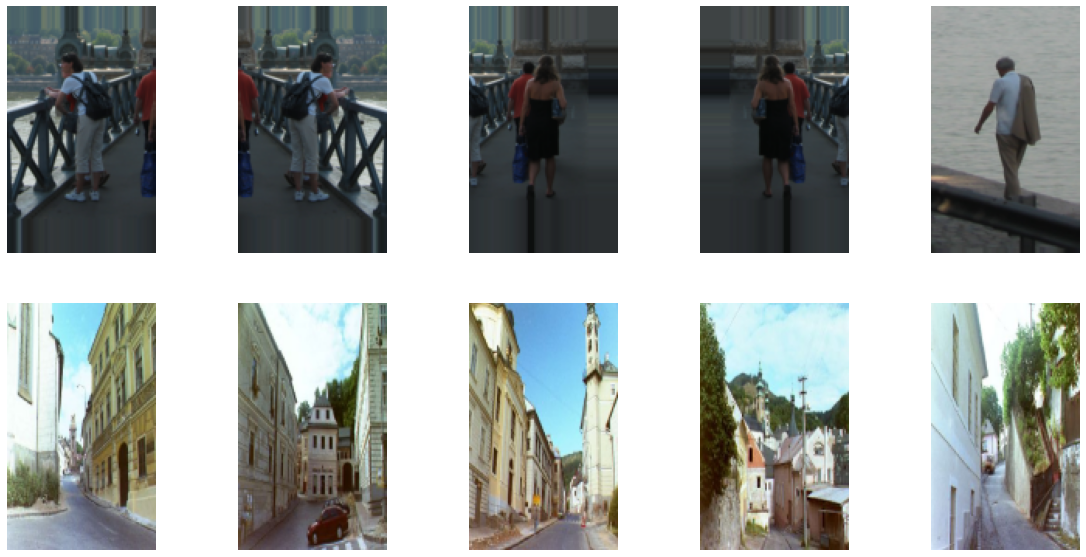

In [308]:
def resize_img(img):
    resized = cv2.resize(img, window_size,interpolation=cv2.INTER_AREA)

    return resized

pos_img_dir = 'INRIAPerson/96X160H96'
neg_img_dir = 'INRIAPerson'

with open('INRIAPerson/train_64x128_H96/pos.lst') as f:
	lineList = f.readlines()
 
with open('INRIAPerson/train_64x128_H96/neg.lst') as f:
	neglineList = f.readlines()

neg_list = [s.rstrip() for s in neglineList]
lineList = [s.rstrip() for s in lineList]
pos_list = [s.replace('train', 'Train') for s in lineList]

pos_images= []
neg_images = []

for img_file in pos_list:
  #print(os.path.join(pos_img_dir, img_file))
  img = cv2.imread(os.path.join(pos_img_dir, img_file))
  #print(img.shape)
  pos_images.append(img)

for img_file in neg_list:
  #print(os.path.join(neg_img_dir, img_file))
  img = cv2.imread(os.path.join(neg_img_dir, img_file))
  resized_img = resize_img(img)
  #print(img.shape)
  neg_images.append(resized_img)

#neg_images = gen_patches(neg_images_data, window_size, 4)
print(len(neg_images))
fig, ax_array = plt.subplots(2, 5, figsize=(20,10))

for index, img in enumerate(pos_images[10:15]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax_array[0, index].imshow(img)
  ax_array[0, index].axis('off')

for index, img in enumerate(neg_images[45:50]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax_array[1, index].imshow(img)
  ax_array[1, index].axis('off')

plt.show()


* **Testing Dataset**

In [15]:

test_neg_img_dir = 'INRIAPerson'
test_pos_img_dir = 'INRIAPerson/70X134H96'
 
with open('INRIAPerson/Test/pos.lst') as f:
	test_pos_list_detect = f.readlines()
 
test_pos_list_detect = [s.rstrip() for s in test_pos_list_detect]
test_pos_detect = [s.replace('test', 'Test') for s in test_pos_list_detect]

test_pos_detect_images = []


for img_file in test_pos_detect[:50]:
  #print(os.path.join(test_neg_img_dir, img_file))
  img = cv2.imread(os.path.join(test_neg_img_dir, img_file))
  if img is not None:
    #resized_img = resize_img(img)
    #print(resized_img.shape)
    test_pos_detect_images.append(img)


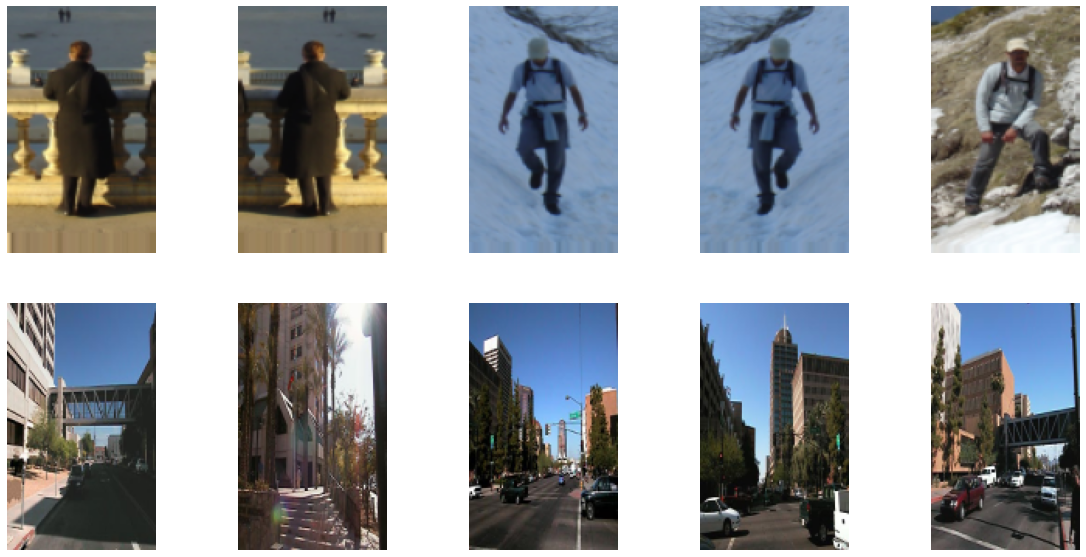

In [309]:
def resize_img(img):
    dim = (96, 160)
    #print(img.shape)
    resized = cv2.resize(img, dim,interpolation=cv2.INTER_AREA)

    return resized

test_neg_img_dir = 'INRIAPerson'
test_pos_img_dir = 'INRIAPerson/70X134H96'
with open('INRIAPerson/test_64x128_H96/pos.lst') as f:
	test_pos_list = f.readlines()
 
with open('INRIAPerson/test_64x128_H96/neg.lst') as f:
	test_neg_list = f.readlines()
 
with open('INRIAPerson/Test/pos.lst') as f:
	test_pos_list_detect = f.readlines()
 
test_neg_list = [s.rstrip() for s in test_neg_list]
test_pos_list = [s.rstrip() for s in test_pos_list]
test_pos_list_detect = [s.rstrip() for s in test_pos_list_detect]

test_pos_list = [s.replace('test', 'Test') for s in test_pos_list]
test_neg_list = [s.replace('test', 'Test') for s in test_neg_list]
test_pos_detect = [s.replace('test', 'Test') for s in test_pos_list_detect]


test_pos_images= []
test_neg_images = []
test_pos_detect_images = []

for img_file in test_pos_list:
  #print(os.path.join(test_pos_img_dir, img_file))
  img = cv2.imread(os.path.join(test_pos_img_dir, img_file))
  if img is not None:
    resized_img = resize_img(img)
    #print(resized_img.shape)
    test_pos_images.append(resized_img)

for img_file in test_neg_list:
  #print(os.path.join(test_neg_img_dir, img_file))
  img = cv2.imread(os.path.join(test_neg_img_dir, img_file))
  if img is not None:
    resized_img = resize_img(img)
    #print(resized_img.shape)
    test_neg_images.append(resized_img)

#test_neg_images = gen_patches(test_neg_images, window_size, 2)

for img_file in test_pos_detect[:50]:
  #print(os.path.join(test_neg_img_dir, img_file))
  img = cv2.imread(os.path.join(test_neg_img_dir, img_file))
  if img is not None:
    #resized_img = resize_img(img)
    #print(resized_img.shape)
    test_pos_detect_images.append(img)

fig, ax_array = plt.subplots(2, 5, figsize=(20,10))

for index, img in enumerate(test_pos_images[10:15]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax_array[0, index].imshow(img)
  ax_array[0, index].axis('off')

for index, img in enumerate(test_neg_images[45:50]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax_array[1, index].imshow(img)
  ax_array[1, index].axis('off')

plt.show()

## 2.Building NN Classifier

In [318]:
with open('pos_train_images.pkl', 'wb') as fid:
     pickle.dump(pos_images, fid)
with open('neg_train_images.pkl', 'wb') as fid:
     pickle.dump(neg_images, fid)
with open('test_pos_train_images.pkl', 'wb') as fid:
     pickle.dump(test_pos_images, fid)
with open('test_neg_train_images.pkl', 'wb') as fid:
     pickle.dump(test_neg_images, fid)

with open('test_pos_detect_images.pkl', 'wb') as fid:
     pickle.dump(test_pos_detect_images, fid)


In [11]:
with open('test_pos_train_images.pkl', 'rb') as pickle_in:
     test_pos_images = pickle.load(pickle_in)

with open('test_neg_train_images.pkl', 'rb') as pickle_in:
     test_neg_images = pickle.load(pickle_in)


In [ ]:
with open('test_pos_detect_images.pkl', 'rb') as fid:
     pickle.dump(test_pos_detect_images, fid)


In [9]:
# The following steps are just for your reference
# You can write in your own way
#Sample setting you can refer to
alpha = 2
beta = 1.5
window_size = (96, 160)
resolution_levels = 4
scale_levels = 5

In [12]:
#Downsample Training Patches
#Extract HOG feature for each resolution 
#Building NN classifier and evaluating
import collections as c

hog_dict = c.defaultdict(list)
hog_dict = {1 : [9,(3,3)],
            2 : [9,(4,4)],
            3 : [9,(6,6)],
            4 : [18,(8,8)]
            }
classifier = {}
accuracy = []

#Please note the first parameter is the width of the image and second parameter is the height of the image.
for R in range(1,5):
  hog_pos = []
  hog_img_pos = []
  labels_pos= []  


  for i in pos_images:
    scale = 1/(alpha**(resolution_levels - R))
    h, w, _  = i.shape
    dim = (int(w*scale) , int(h*scale))
    img  = cv2.resize(i,dim)
    hog_descriptors, hog_image = hog(img, orientations=hog_dict[R][0], pixels_per_cell=hog_dict[R][1], cells_per_block=(2,2), visualize=True)
    
    hog_pos.append(hog_descriptors)
    hog_img_pos.append(hog_image)
    labels_pos.append(1)

  for i in neg_images:
    scale = 1/(alpha**(resolution_levels - R))
    h, w, _  = i.shape
    dim = (int(w*scale) , int(h*scale))
    img  = cv2.resize(i,dim)
    hog_descriptors, hog_image = hog(img, orientations=hog_dict[R][0], pixels_per_cell=hog_dict[R][1], cells_per_block=(2,2), visualize=True)
    
    hog_pos.append(hog_descriptors)
    hog_img_pos.append(hog_image)
    labels_pos.append(0)
  
  print("Image shape after downsampling resolution: {0} - {1} in terms of (width, height)".format(R, dim))
  X_train = np.array(hog_pos)
  y_train = np.array(labels_pos)
  #print(X_train.shape, y_train.shape)
  model = KNeighborsClassifier(n_neighbors=1)
  m = model.fit(X_train,y_train)
  classifier[R] = m
  #starting with the test dataset

for R in range(1,5):
  test_hog_pos = []
  test_hog_img_pos = []
  test_labels_pos= []

  for i in test_pos_images:
    scale = 1/(alpha**(resolution_levels - R))
    h, w, _  = i.shape
    dim = (int(w*scale) , int(h*scale))
    img  = cv2.resize(i,dim)
    hog_descriptors, hog_image = hog(img, orientations=hog_dict[R][0], pixels_per_cell=hog_dict[R][1], cells_per_block=(2,2), visualize=True)
    
    test_hog_pos.append(hog_descriptors)
    test_hog_img_pos.append(hog_image)
    test_labels_pos.append(1)

  for i in test_neg_images:
    scale = 1/(alpha**(resolution_levels - R))
    h, w, _  = i.shape
    dim = (int(w*scale) , int(h*scale))
    img  = cv2.resize(i,dim)
    hog_descriptors, hog_image = hog(img, orientations=hog_dict[R][0], pixels_per_cell=hog_dict[R][1], cells_per_block=(2,2), visualize=True)
    #print(type(hog_descriptors))
    test_hog_pos.append(hog_descriptors)
    test_hog_img_pos.append(hog_image)
    test_labels_pos.append(0)


  X_test = np.array(test_hog_pos)
  y_test = np.array(test_labels_pos)
  Pred_y = classifier[R].predict(X_test)
  accuracy.append(metrics.accuracy_score(y_test, Pred_y))
  print("Accuracy for resolution {0}: {1}".format(R, round(accuracy[R-1]*100, 2)))
  

Image shape after downsampling resolution: 1 - (12, 20) in terms of (width, height)
Image shape after downsampling resolution: 2 - (24, 40) in terms of (width, height)
Image shape after downsampling resolution: 3 - (48, 80) in terms of (width, height)
Image shape after downsampling resolution: 4 - (96, 160) in terms of (width, height)
Accuracy for resolution 1: 73.53
Accuracy for resolution 2: 85.24
Accuracy for resolution 3: 84.1
Accuracy for resolution 4: 80.75


In [13]:
with open('classifiers.pkl', 'wb') as fid:
     pickle.dump(classifier, fid)

## 3.Detection

In [16]:
alpha = 2
beta = 1.5
window_size = (96, 160)
resolution_levels = 4
scale_levels = 5

import datetime
import re
# The following steps are just for your reference
# You can write in your own way

hog_dict = {1 : [9,(3,3),(1,1)],
            2 : [9,(4,4),(2,2)],
            3 : [9,(6,6),(4,4)],
            4 : [18,(8,8),(8,8)]
            }
window_size = (96,160)

scale_hog = []
score_matrix  = {}

img_detections_loop = []
for i in test_pos_detect_images[:5]:
  
  for r in range(1,5):
    
    scale = alpha**(resolution_levels - r)

    width_window = int(window_size[0]/scale)
    height_window = int(window_size[1]/scale)
    print("Window Size:", width_window, height_window)

    for s in range(1, 6) :#scale_levels + 1):
      
      scale_res = 1.0 / (alpha**(resolution_levels - r) * beta**(scale_levels - s))
      h, w, _  = i.shape
      dim = (int(w*scale_res) , int(h*scale_res))
      img  = cv2.resize(i,dim)
      height_img, width_img , _  = img.shape
      score_matrix[(r,s)] = np.zeros((img.shape[0], img.shape[1]))

      print("Image size after rescaling:", width_img, height_img)

      if width_window > width_img or height_window > height_img:
        continue      
      for det_y in range(0, height_img - height_window +1 , hog_dict[r][2][1]):
        for det_x in range(0, width_img - width_window + 1, hog_dict[r][2][0]):
          if r ==1:
            #print(det_y, det_y + height_window, det_x, det_x + width_window)
            detector_window = img[det_y: det_y + height_window, det_x: det_x + width_window]
            #print(img.shape,  detector_window.shape)
            #print(det_y, det_y + height, det_x, det_x + width)
            hog_descriptors, hog_image = hog(detector_window, orientations=hog_dict[r][0], pixels_per_cell=hog_dict[r][1], cells_per_block=(2,2), visualize=True)
            #print(type(hog_descriptors))
            hog_descriptors = hog_descriptors.reshape(1, -1)
            #print(hog_descriptors.shape)
            result = classifier[r].predict(hog_descriptors)
            #print(result, det_y, det_x)
            
            if int(result[0]) == 1:
              score_matrix[(r,s)][det_y, det_x] =  1

          if r != 1:
            continue
            
  img_detections_loop.append(score_matrix)

Window Size: 12 20
Image size after rescaling: 12 17
Image size after rescaling: 18 26
Image size after rescaling: 27 40
Image size after rescaling: 40 60
Image size after rescaling: 61 90
Window Size: 24 40
Image size after rescaling: 24 35
Image size after rescaling: 36 53
Image size after rescaling: 54 80
Image size after rescaling: 81 120
Image size after rescaling: 122 180
Window Size: 48 80
Image size after rescaling: 48 71
Image size after rescaling: 72 106
Image size after rescaling: 109 160
Image size after rescaling: 163 240
Image size after rescaling: 245 360
Window Size: 96 160
Image size after rescaling: 96 142
Image size after rescaling: 145 213
Image size after rescaling: 218 320
Image size after rescaling: 327 480
Image size after rescaling: 491 720
Window Size: 12 20
Image size after rescaling: 8 13
Image size after rescaling: 12 19
Image size after rescaling: 18 29
Image size after rescaling: 27 44
Image size after rescaling: 41 66
Window Size: 24 40
Image size after 

In [42]:
scale = alpha**(resolution_levels - 1)
scale_res_mul = (alpha**(resolution_levels - 1) * beta**(scale_levels - s))

img_detections = {} #list of mask lists for each image

mask_list = []
width_window = int(window_size[0]/scale)
height_window = int(window_size[1]/scale)

for i , img in enumerate(test_pos_detect_images[:5]):
  for s in range(1, 6) :
    height, width =  img_detections_loop[i][(1,s)].shape
    
    for row in range(0,height):
      for col in range(0, width):
        
        if img_detections_loop[i][(1,s)][row, col] == 1:
          mask_array = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
          
          mask = cv2.rectangle(mask_array, (int(col*scale_res_mul), int(row*scale_res_mul)), (height_window, width_window), 1, -1) #(0, 255, 0), 2)
          mask_list.append(mask)

  img_detections[i] = mask_list
#plt.imshow(final_img)   

In [43]:
def load_annotation(prefix, lst):
    masks = {}
    with open(prefix + lst, 'r') as f:
        file_list = f.readlines()
    file_list = [prefix + '/'.join(i[:-1].split('/')[1:]) for i in file_list]
    for i, file in enumerate(file_list):
        with open(file, 'r', encoding='latin-1') as f:
            lines = f.readlines()
        masks[i] = []
        mask = None
        for line in lines:
            if mask is not None:
                match = re.match( r'Bounding box .* \(([0-9]+), ([0-9]+)\) - \(([0-9]+), ([0-9]+)\)', line)
                if match:
                    pt1 = (int(match.group(1)), int(match.group(2)))
                    pt2 = (int(match.group(3)), int(match.group(4)))
                    mask = cv2.rectangle(mask, pt1, pt2, 1, -1)
                    masks[i].append(mask)
            else:
                match = re.match( r'Image size.* ([0-9]+) x ([0-9]+) x ([0-9])', line)
                if match:
                    mask = np.zeros((int(match.group(2)), int(match.group(1))), dtype=np.uint8)
            """
            plt.figure()
            plt.imshow(mask)
            plt.show()
            """
        if mask is None:
            print(f"Error while parsing {file}")
            break
        #masks.append(mask)
    print(f"Load {len(masks)} annotations.")
    return masks
        
test_gt_mask = load_annotation('./INRIAPerson/Test/', 'annotations.lst');



Load 288 annotations.


In [60]:
def getIOU(box, ground_truth):
  intersection = np.sum(cv2.bitwise_and(box, ground_truth))
  union = np.sum(cv2.bitwise_or(box, ground_truth))
  if union == 0:
    return 1
  return float(intersection) /union

predicted_iou = []

for i in range(len(img_detections)):
  for predicted_box in img_detections[i]:
    max_seen_so_far = 0
    for box in test_gt_mask[i]:
      if predicted_box.shape[0] == box.shape[0] and predicted_box.shape[1] == box.shape[1]:
        iou_i_j = getIOU(box , predicted_box)
      
        max_seen_so_far = max(iou_i_j   , max_seen_so_far)
        predicted_iou.append(max_seen_so_far)

np.sum(predicted_iou) / len(predicted_iou)

0.03441939492717575

# Problem 2: Image Classification with Bag of SIFT Representation + SVM Classifer(50 + 10 points)

## **Description**
---
In this problem, we will examine the task of image classification using bags of quantized local features and linear classifiers learned by support vector machines. We will implement a basic bag of words model and
classify images into one of 10 categories by training and testing on **a small subset** of **miniImagenet** dataset (downloaded from https://awesomeopensource.com/project/oscarknagg/few-shot).

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

## **0.Data Preparation(0 points)**
Load the data and show the sample of each class.

## **1.Bag of SIFT Representation (30 points)**
Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. 

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 200 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 200. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

a. {**10** points} Sample some keypoints and extract SIFT feature.

b. {**15** points} Do the clustering to fit the bag of SIFT model.

c. {**5** points} Extract the feature using the bag of SIFT model.</br>
**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to **densely sample keypoints** in a grid with certain step
  size (sampling density) and scale. 
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary.



**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use [`cv2.Keypoint()`](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint) to generate key points;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints.

- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

## **2.One-vs-all SVMs(20 points)**

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 10-way classification problem
(the library has handled it for you). To decide which of 10 categories a test
case belongs to, you will train 10 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'bird' vs 'non-bird',
'cat' vs 'non-cat', etc. All 10 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'cat' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'bird' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
'cat' even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
**C** which controls how strongly regularized the model is. Your
accuracy will be very sensitive to **C**, so be sure to try many values.


**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

**Note**: 
- **You need to get at least 20% accuracy to get full points for this problem.**

## **3.Bonus Problem(Bonus 10 points)**

You need to get at least **40%** accuracy to get the bonus. For this, you can use any methods you want.


## 0.Data Preparation
----

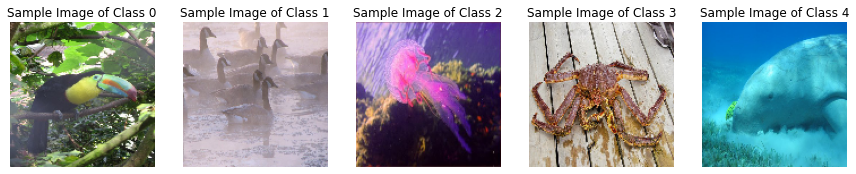

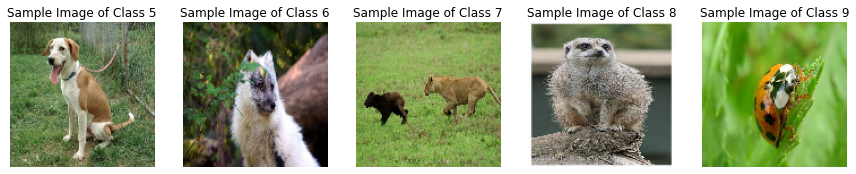

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_train = pickle.load(fo, encoding='bytes')
        dict_test = pickle.load(fo, encoding='bytes')
    return dict_train, dict_test

# load data from pickle files and sample a small subset for this homework
train_data_dict, test_data_dict = unpickle('miniImageNet.pkl') 
train_label = train_data_dict['labels']  
train_data = train_data_dict['data']  

test_label = test_data_dict['labels']   
test_data = test_data_dict['data'] 

# reshape data
train_data = [d.reshape(3, 128, 128).transpose(1,2,0) for d in train_data]
test_data = [d.reshape(3, 128, 128).transpose(1,2,0) for d in test_data]

# plot 10 training images from 10 classes
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(i))
    plt.imshow(cv2.cvtColor(train_data[500*i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(i+5))
    plt.imshow(cv2.cvtColor(train_data[500*(i+5)], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

## 1.Bag of SIFT Representation
----

In [ ]:
from sklearn import neighbors

np.random.seed(56)
##########--WRITE YOUR CODE HERE--##########

sift = cv2.xfeatures2d.SIFT_create()
sift_features = []
step = 20
scale = 8
keypoints = [cv2.KeyPoint(i, j, scale) for i in range(step, 180, step) for j in range(step, 180, step)]

for image in train_data:
    kp, des = sift.compute(image, keypoints)
    sift_features.extend(des)

sift_features = np.array(sift_features)

n_clusters = 50
kmeans_classifier = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_clusters = kmeans_classifier.fit(sift_features)

training_image_histograms = []
test_image_histograms = []

for image in train_data:
    kp, des = sift.compute(image, keypoints)
    histogram = np.zeros(n_clusters)
    n_keypoints = np.size(kp)
    for feature in des:
        index = kmeans_classifier.predict([feature])
        histogram[index] += 1/n_keypoints
    training_image_histograms.append(histogram)

training_image_histograms = np.array(training_image_histograms)

for image in test_data:
    kp, des = sift.compute(image, keypoints)
    histogram = np.zeros(n_clusters)
    n_keypoints = np.size(kp)
    for feature in des:
        index = kmeans_classifier.predict([feature])
        histogram[index] += 1/n_keypoints
    test_image_histograms.append(histogram)

test_image_histograms = np.array(test_image_histograms)


## 2.One-vs-all SVMs

In [ ]:
from sklearn import svm
##########--WRITE YOUR CODE HERE--##########

classifier = svm.SVC(C=1.0) # Linear Kernel
classifier.fit(training_image_histograms, train_label)    
test_label_pred = classifier.predict(test_image_histograms)

##########-------END OF CODE-------##########
accuracy = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
print("The accuracy of Bag of SIFT Representation + one-vs-all SVMs model is {:.2f}%".format(accuracy*100))

The accuracy of Bag of SIFT Representation + one-vs-all SVMs model is 34.20%


## Submission guidelines
---
Your need to submit a single zip file to Blackboard described as follow.

Please generate a pdf file that includes a ***google shared link*** (explained in the next paragraph). This pdf file should be named as ***Surname_Givenname_SBUID_pa*\*.pdf** (example: Jordan_Michael_111234567_pa3.pdf for this assignment).

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_pa**** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_pa3
        |---INRIAPerson
        |---CSE527-PA3-fall21.ipynb
        |---miniImageNet.pkl
```
Note that this folder should be in your Google Drive with your Stony Brook account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: ***bjha@cs.stonybrook.edu***, ***li.wenchen@stonybrook.edu***, ***yifeng.huang@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **UNCHECK** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

To submit to Blackboard, zip ***Surname_Givenname_SBUID_pa*\*.pdf** and ***Surname_Givenname_SBUID_pa**** folder together and name your zip file as ***Surname_Givenname_SBUID_pa*\*.zip**. 

**DO NOT upload INRIA dataset to Blackboard.**

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_pa3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Edstem. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Edstem and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

